# Imports

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
from torchtext.legacy.data import Field
from torchtext.legacy.datasets import LanguageModelingDataset
from torchtext.legacy.data import BPTTIterator
from src.model import LSTMModel
from src.helper import counter, get_fables
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hyperparameters

In [4]:
BATCH_SIZE = 64
EMBEDDING_DIM = 1024
HIDDEN_SIZE = 1024
LAYERS = 2
BPTT_LEN = 256
model_parameters = {
    'batch_size' : BATCH_SIZE,
    'embedding_dim': EMBEDDING_DIM,
    'hidden_size': HIDDEN_SIZE,
    'num_layers': LAYERS
}
bonus_path = os.path.join('data', "donaldtrump.txt")
book_path = os.path.join(os.path.join("data","books"), "AesopsFables.txt")

# Training Class

In [5]:
class Trainer():
    def __init__(self, model_parameters : dict, path : str, bptt_len : int, samples : list):
        """
        We create a `LanguageModelingDataset` object from the `path` argument, which is a path to a text
        file. We then create a `BPTTIterator` object from the `LanguageModelingDataset` object. We then
        create a `LSTMModel` object from the `model_parameters` argument, which is a dictionary of model
        parameters. We then create an `Adam` optimizer object from the `LSTMModel` object
        
        :param model_parameters: a dictionary containing the parameters for the model
        :type model_parameters: dict
        :param path: the path to the dataset
        :type path: str
        :param bptt_len: The length of the sequence to be fed into the model
        :type bptt_len: int
        :param samples: list of strings to be used for training
        :type samples: list
        """
        self.samples = samples
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        _split_chars = lambda x: list(x) 
        self.train_field = Field(tokenize=_split_chars ,init_token ='<sos>',eos_token ='<eos>')
        train_dataset = LanguageModelingDataset(
            path = path,
            text_field=self.train_field
        )
        self.train_field.build_vocab(train_dataset)
        self.bptt_iterator = BPTTIterator(
            dataset= train_dataset,
            batch_size = model_parameters['batch_size'],
            bptt_len = bptt_len,
            shuffle = False
        )
        self.model = LSTMModel(**model_parameters, vocab_size = len(self.train_field.vocab)).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

        
    def predict(self, model : LSTMModel, prompt : str,sequence_length : int, method : str = 'greedy') -> str:
        """
        The function takes in a model, a prompt, a sequence length, and a method. It then generates a
        sentence of the specified length using the specified method
        
        :param model: the model to use for prediction
        :type model: LSTMModel
        :param prompt: The prompt to start the sentence with
        :type prompt: str
        :param sequence_length: The length of the generated sequence
        :type sequence_length: int
        :param method: 'greedy' or 'random', defaults to greedy
        :type method: str (optional)
        :return: A string of the generated sentence
        """
        model.eval()
        generated_sentence=[]
        prompt = torch.tensor([self.train_field.vocab.stoi[t] for t in self.train_field.tokenize(prompt)]).long().to(self.device)
        hidden = None
        Softmax1D = nn.Softmax(dim=1)
        if method == 'greedy':
            out,hidden=model(prompt.view(-1,1),hidden)
            ix = torch.argmax(Softmax1D(out), dim=1)[len(prompt)-1]
            for i in range(sequence_length):
                out,hidden=model(ix.view(-1,1),hidden)
                ix = torch.argmax(Softmax1D(out), dim=1)
                generated_sentence.append(self.train_field.vocab.itos[ix])
        if method == 'random':
            out,hidden=model(prompt.view(-1,1),hidden)
            ix = torch.multinomial(Softmax1D(out),1)[len(prompt)-1]
            for i in range(sequence_length):
                out,hidden=model(ix.view(-1,1),hidden)
                ix = torch.multinomial(Softmax1D(out),1)
                generated_sentence.append(self.train_field.vocab.itos[ix])
        return ''.join(generated_sentence)

    def train_model(self, num_epochs : int) -> LSTMModel:
        """
        The function takes in the number of epochs and the model and trains the model for the given
        number of epochs
        
        :param num_epochs: Number of epochs to train for
        :return: The model is being returned.
        """
        # vocab_size = 
        loss_fn = nn.CrossEntropyLoss()
        total_steps = 0
        loss_plot =[]
        perp_plot=[]
        for epoch in range(1, num_epochs+1):
            cost = 0
            num_steps =0
            hidden=None
            print("___________________________________________________________________________")
            print(f"EPOCH: {epoch}")
            print(f'Total Steps: {total_steps}')
            print("___________________________________________________________________________")
            for batch in tqdm(self.bptt_iterator):
                self.model.train()
                self.optimizer.zero_grad()
                output, hidden = self.model(batch.text.to(self.device),hidden)
                hidden = (hidden[0].detach(), hidden[1].detach())
                targets = batch.target
                targets = targets.view(targets.shape[0]*targets.shape[1]).to(self.device)
                out = output.view(-1, self.model.vocab_size)
                loss = loss_fn(out,targets)
                cost += loss.item()
                num_steps += 1
                total_steps+=1
                loss.backward()
                self.optimizer.step()
            if epoch%10==0:
                self.model.eval()
                for prompt in self.samples:
                    print()
                    print('Greedy decoding')
                    gen_text = self.predict(self.model, prompt, 100)
                    print(f'Sample prompt: {prompt} | generated text: {gen_text}')
                    print()
                    print('Random decoding')
                    gen_text = self.predict(self.model, prompt, 100, method='random')
                    print(f'Sample prompt: {prompt} | generated text: {gen_text}')
                    print()

            perplexity = np.exp(cost/num_steps)
            loss_plot.append(cost/num_steps)
            perp_plot.append(perplexity)
            print(f"Training Loss: {cost/num_steps}, \n Training perplexity: {perplexity}")
        _, ax1 = plt.subplots()
        _, ax2 = plt.subplots()
        ax1.plot(loss_plot,'coral')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.title.set_text('Train Loss Plot')
        ax1.legend(["Train Loss"])
        ax2.plot(perp_plot,'deepskyblue')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.title.set_text('Train Perplexity Plot')
        ax2.legend(["Train Perplexity"])
        plt.show()
        return self.model

# Train the fable and the trump models

Training on data from: data/books/AesopsFables.txt
Fable Analysis
Word Count:  5033
Line Count:  5033
Char Count:  138881
Sentence Count:  1880
Vocab Count:  108
Count:  11
___________________________________________________________________________
EPOCH: 1
Total Steps: 0
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  2.12it/s]


Training Loss: 3.5015296936035156, 
 Training perplexity: 33.16614721795255
___________________________________________________________________________
EPOCH: 2
Total Steps: 11
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  2.10it/s]


Training Loss: 2.7153718038038774, 
 Training perplexity: 15.11022706752168
___________________________________________________________________________
EPOCH: 3
Total Steps: 22
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  2.08it/s]


Training Loss: 2.362034494226629, 
 Training perplexity: 10.612520615747519
___________________________________________________________________________
EPOCH: 4
Total Steps: 33
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  2.06it/s]


Training Loss: 2.1242009943181817, 
 Training perplexity: 8.36621016742036
___________________________________________________________________________
EPOCH: 5
Total Steps: 44
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  2.07it/s]


Training Loss: 1.9490860267118975, 
 Training perplexity: 7.022266482693182
___________________________________________________________________________
EPOCH: 6
Total Steps: 55
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  2.08it/s]


Training Loss: 1.8146450519561768, 
 Training perplexity: 6.1388968012743215
___________________________________________________________________________
EPOCH: 7
Total Steps: 66
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  2.06it/s]


Training Loss: 1.7046420899304477, 
 Training perplexity: 5.499417018205378
___________________________________________________________________________
EPOCH: 8
Total Steps: 77
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  2.04it/s]


Training Loss: 1.6090871745889836, 
 Training perplexity: 4.998246618281054
___________________________________________________________________________
EPOCH: 9
Total Steps: 88
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  2.00it/s]


Training Loss: 1.526662750677629, 
 Training perplexity: 4.602790503100714
___________________________________________________________________________
EPOCH: 10
Total Steps: 99
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.98it/s]



Greedy decoding
Sample prompt: Dogs like best to | generated text: the said, “I will be and the Fox and the Fox and the Fox and the Fox and the Fox and the Fox and the

Random decoding
Sample prompt: Dogs like best to | generated text: the bond, and way, has<eos>esten from paw, and lause of hissions<eos>fell eat into<eos>dy often, and atted to be


Greedy decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: to the said, “I will be and the Fox and the Fox and the Fox and the Fox and the Fox and the Fox and 

Random decoding
Sample prompt: THERE were once some Frogs who lived together | generated text:  What you hand of had<eos>do, and stighp, the gathing this seerss,” reploated at, he<eos>kill to rempent of 


Greedy decoding
Sample prompt: THE WOMAN AND HER HEN | generated text: <eos><eos>A CORTIND AND THE FOX<eos><eos><eos>A WOLF and the Fox and the Fox and the Fox and the Fox and the Fox and the

Random decoding
Sample prompt: THE WOMAN AND HER HEN

100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


Training Loss: 1.389375307343223, 
 Training perplexity: 4.012342788864317
___________________________________________________________________________
EPOCH: 12
Total Steps: 121
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.96it/s]


Training Loss: 1.3393106027082964, 
 Training perplexity: 3.8164115744441025
___________________________________________________________________________
EPOCH: 13
Total Steps: 132
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.94it/s]


Training Loss: 1.2854208729483865, 
 Training perplexity: 3.6161895933633246
___________________________________________________________________________
EPOCH: 14
Total Steps: 143
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.96it/s]


Training Loss: 1.2326143980026245, 
 Training perplexity: 3.4301856943353872
___________________________________________________________________________
EPOCH: 15
Total Steps: 154
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.93it/s]


Training Loss: 1.1828736500306563, 
 Training perplexity: 3.2637395853885867
___________________________________________________________________________
EPOCH: 16
Total Steps: 165
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


Training Loss: 1.1391574577851729, 
 Training perplexity: 3.124135040341952
___________________________________________________________________________
EPOCH: 17
Total Steps: 176
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Training Loss: 1.097182273864746, 
 Training perplexity: 2.9957130215417895
___________________________________________________________________________
EPOCH: 18
Total Steps: 187
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


Training Loss: 1.0647794550115413, 
 Training perplexity: 2.900199289102725
___________________________________________________________________________
EPOCH: 19
Total Steps: 198
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


Training Loss: 1.0292153033343228, 
 Training perplexity: 2.798868709829268
___________________________________________________________________________
EPOCH: 20
Total Steps: 209
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.83it/s]



Greedy decoding
Sample prompt: Dogs like best to | generated text: the water the fables of the food of the food of the food of the food of the food of the food of the 

Random decoding
Sample prompt: Dogs like best to | generated text: get upon its<eos>endeable upon him with of the tirst refund<eos>try the edges, pution the poor Donkeywere ap


Greedy decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: he was the fables of the food of the food of the food of the food of the food of the food of the foo

Random decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: themed<eos>timeed in<eos>from the primit of a slife, cannot free their happened his xittening courtedicλly.<eos>


Greedy decoding
Sample prompt: THE WOMAN AND HER HEN | generated text: <eos><eos>A DOG once came the Fox the same day the fable for the fables for the first before the first that 

Random decoding
Sample prompt: THE WOMAN AND HER HEN | generated

100%|██████████| 11/11 [00:06<00:00,  1.82it/s]


Training Loss: 0.9360931624065746, 
 Training perplexity: 2.5499994982524608
___________________________________________________________________________
EPOCH: 22
Total Steps: 231
___________________________________________________________________________


100%|██████████| 11/11 [00:06<00:00,  1.82it/s]


Training Loss: 0.8929724855856462, 
 Training perplexity: 2.442378807746455
___________________________________________________________________________
EPOCH: 23
Total Steps: 242
___________________________________________________________________________


100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


Training Loss: 0.861543292349035, 
 Training perplexity: 2.3668105572027143
___________________________________________________________________________
EPOCH: 24
Total Steps: 253
___________________________________________________________________________


100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


Training Loss: 0.8406629399819807, 
 Training perplexity: 2.3179030981848285
___________________________________________________________________________
EPOCH: 25
Total Steps: 264
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


Training Loss: 0.7983544523065741, 
 Training perplexity: 2.2218817062890017
___________________________________________________________________________
EPOCH: 26
Total Steps: 275
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.7382796135815707, 
 Training perplexity: 2.092332795424393
___________________________________________________________________________
EPOCH: 27
Total Steps: 286
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


Training Loss: 0.6981368552554738, 
 Training perplexity: 2.0100042877053967
___________________________________________________________________________
EPOCH: 28
Total Steps: 297
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


Training Loss: 0.6558807383884083, 
 Training perplexity: 1.9268388111804573
___________________________________________________________________________
EPOCH: 29
Total Steps: 308
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


Training Loss: 0.612954394383864, 
 Training perplexity: 1.8458767989390834
___________________________________________________________________________
EPOCH: 30
Total Steps: 319
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.86it/s]



Greedy decoding
Sample prompt: Dogs like best to | generated text: meet him corracted him to come and straight to the ground,<eos>that he was not a bird, but he was not a 

Random decoding
Sample prompt: Dogs like best to | generated text: Gree yourself as<eos>insubsed on his false made the ambasked of way, she stretched his Mother to strong 


Greedy decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: that he could not reach the trees, the<eos>statue of a man came to the tree, he mounted to the ground be

Random decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: to her publes for herself<eos>one browsed him by to the one to come out of good turn to his crike laughi


Greedy decoding
Sample prompt: THE WOMAN AND HER HEN | generated text: <eos><eos>A MONKEY and a Cat being that he was not a bird, but the man had only took the ground, and the Fox

Random decoding
Sample prompt: THE WOMAN AND HER HEN | generated tex

100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


Training Loss: 0.5768304467201233, 
 Training perplexity: 1.7803864486447958
___________________________________________________________________________
EPOCH: 32
Total Steps: 341
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.5365211855281483, 
 Training perplexity: 1.7100475643347197
___________________________________________________________________________
EPOCH: 33
Total Steps: 352
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


Training Loss: 0.4959371333772486, 
 Training perplexity: 1.6420363252955927
___________________________________________________________________________
EPOCH: 34
Total Steps: 363
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


Training Loss: 0.4635348076170141, 
 Training perplexity: 1.5896832898486923
___________________________________________________________________________
EPOCH: 35
Total Steps: 374
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


Training Loss: 0.4412284872748635, 
 Training perplexity: 1.5546158717089067
___________________________________________________________________________
EPOCH: 36
Total Steps: 385
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


Training Loss: 0.4130805324424397, 
 Training perplexity: 1.5114667431413276
___________________________________________________________________________
EPOCH: 37
Total Steps: 396
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.382128352468664, 
 Training perplexity: 1.4654001607909324
___________________________________________________________________________
EPOCH: 38
Total Steps: 407
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.83it/s]


Training Loss: 0.34603663195263257, 
 Training perplexity: 1.4134543924636844
___________________________________________________________________________
EPOCH: 39
Total Steps: 418
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.3213204633105885, 
 Training perplexity: 1.3789474121474437
___________________________________________________________________________
EPOCH: 40
Total Steps: 429
___________________________________________________________________________


100%|██████████| 11/11 [00:06<00:00,  1.83it/s]



Greedy decoding
Sample prompt: Dogs like best to | generated text: the danger. Let us be the water.<eos><eos>“What good have to say to the terms of the water, by the way being

Random decoding
Sample prompt: Dogs like best to | generated text: the TartA Bull<eos>do not hart to her by and a Currier stood with it and heard the water.<eos><eos>“Can you swim


Greedy decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: in the water.<eos><eos>“What good lay, but that was only beak, and a Weasel caught in the tail.”<eos><eos>“No, thank

Random decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: in the bank.<eos><eos><eos><eos><eos>THE APASTING, AND ALD WALFLY MULES<eos><eos><eos>A PLISERAHIDID once made a other onap before t


Greedy decoding
Sample prompt: THE WOMAN AND HER HEN | generated text: <eos><eos>A WOMAN had a Hen that no one who had been the dinner of the water, became friends<eos>when he began t

Random decod

100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


Training Loss: 0.29525523565032263, 
 Training perplexity: 1.3434692161687665
___________________________________________________________________________
EPOCH: 42
Total Steps: 451
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.2618998478759419, 
 Training perplexity: 1.2993963986030868
___________________________________________________________________________
EPOCH: 43
Total Steps: 462
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.83it/s]


Training Loss: 0.23606735196980563, 
 Training perplexity: 1.266259592372717
___________________________________________________________________________
EPOCH: 44
Total Steps: 473
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.83it/s]


Training Loss: 0.21783268722620877, 
 Training perplexity: 1.2433790170225743
___________________________________________________________________________
EPOCH: 45
Total Steps: 484
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.19976684992963617, 
 Training perplexity: 1.2211180212156714
___________________________________________________________________________
EPOCH: 46
Total Steps: 495
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.1782458871603012, 
 Training perplexity: 1.1951191495629214
___________________________________________________________________________
EPOCH: 47
Total Steps: 506
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


Training Loss: 0.15744233741001648, 
 Training perplexity: 1.1705132612094418
___________________________________________________________________________
EPOCH: 48
Total Steps: 517
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.14476064050739462, 
 Training perplexity: 1.1557628943368767
___________________________________________________________________________
EPOCH: 49
Total Steps: 528
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.1301800933751193, 
 Training perplexity: 1.1390334972411307
___________________________________________________________________________
EPOCH: 50
Total Steps: 539
___________________________________________________________________________


100%|██████████| 11/11 [00:06<00:00,  1.83it/s]



Greedy decoding
Sample prompt: Dogs like best to | generated text: eat at him,<eos>and greedy as to be as desperate as great candbed to be stickeny accepted in the<eos>water. 

Random decoding
Sample prompt: Dogs like best to | generated text: amuse himself at time that was glad at the original Oak. Great returns<eos>or emplieated for this eyes<eos>a


Greedy decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: in<eos>the collection are in the command<eos>of the river. As the water carried it away remedy about<eos>firm. T

Random decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: in<eos>the Ants was drowned.<eos><eos>The hogs as served a stickane dawned, and knew he away from him to<eos>spring 


Greedy decoding
Sample prompt: THE WOMAN AND HER HEN | generated text: <eos><eos>A THRIFTY Woman kept a Hen that could be still to itself of<eos>avainsanguagand to consider what could

Random decoding
Sample prompt: THE W

100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


Training Loss: 0.11151364784349095, 
 Training perplexity: 1.1179690017673767
___________________________________________________________________________
EPOCH: 52
Total Steps: 561
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


Training Loss: 0.09307985414158214, 
 Training perplexity: 1.0975493756320476
___________________________________________________________________________
EPOCH: 53
Total Steps: 572
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.08056241070682352, 
 Training perplexity: 1.0838964912774982
___________________________________________________________________________
EPOCH: 54
Total Steps: 583
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


Training Loss: 0.06770942156965082, 
 Training perplexity: 1.0700543285917483
___________________________________________________________________________
EPOCH: 55
Total Steps: 594
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.055899836122989655, 
 Training perplexity: 1.0574917559574482
___________________________________________________________________________
EPOCH: 56
Total Steps: 605
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


Training Loss: 0.045805785804986954, 
 Training perplexity: 1.0468710739891962
___________________________________________________________________________
EPOCH: 57
Total Steps: 616
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


Training Loss: 0.040103873068636116, 
 Training perplexity: 1.040918892016541
___________________________________________________________________________
EPOCH: 58
Total Steps: 627
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.03641099431975321, 
 Training perplexity: 1.0370819937214175
___________________________________________________________________________
EPOCH: 59
Total Steps: 638
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.035148761827837334, 
 Training perplexity: 1.0357737809401912
___________________________________________________________________________
EPOCH: 60
Total Steps: 649
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.85it/s]



Greedy decoding
Sample prompt: Dogs like best to | generated text: eat at home. And you will get them<eos>easily.”<eos><eos><eos><eos><eos>THE MISER<eos><eos><eos>A MISER who had buried a lump of gold in

Random decoding
Sample prompt: Dogs like best to | generated text: ear about noisela<eos>providing to be acceptaly together.<eos><eos>They were a lot of the food which his friends


Greedy decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: in perfect security in a<eos>beautiful lake. They were a large company, and were very comfortable,<eos>but t

Random decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: in perfect mean.<eos><eos>The Argodes and the Hen grew very fat and sleek; but she<eos>forgot to elect a Fine wa


Greedy decoding
Sample prompt: THE WOMAN AND HER HEN | generated text: <eos><eos>A THRIFTY Woman kept a Hen that could be depended on to lay an egg<eos>every morning. The watchful Wom

Random decod

100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


Training Loss: 0.027635549449107864, 
 Training perplexity: 1.0280209533373255
___________________________________________________________________________
EPOCH: 62
Total Steps: 671
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


Training Loss: 0.023981252685189247, 
 Training perplexity: 1.0242711153775728
___________________________________________________________________________
EPOCH: 63
Total Steps: 682
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


Training Loss: 0.021356963298537514, 
 Training perplexity: 1.0215866555008477
___________________________________________________________________________
EPOCH: 64
Total Steps: 693
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


Training Loss: 0.019896251742135395, 
 Training perplexity: 1.020095501405438
___________________________________________________________________________
EPOCH: 65
Total Steps: 704
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


Training Loss: 0.01767748585817489, 
 Training perplexity: 1.0178346573778334
___________________________________________________________________________
EPOCH: 66
Total Steps: 715
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.016597446562214332, 
 Training perplexity: 1.0167359493817822
___________________________________________________________________________
EPOCH: 67
Total Steps: 726
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


Training Loss: 0.016361320729960094, 
 Training perplexity: 1.016495900101585
___________________________________________________________________________
EPOCH: 68
Total Steps: 737
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.015405807051468979, 
 Training perplexity: 1.0155250882507723
___________________________________________________________________________
EPOCH: 69
Total Steps: 748
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


Training Loss: 0.01482875653627244, 
 Training perplexity: 1.0149392480213617
___________________________________________________________________________
EPOCH: 70
Total Steps: 759
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.85it/s]



Greedy decoding
Sample prompt: Dogs like best to | generated text: eat at home, and<eos>he was not a Frog left in the lake. Petrible drinking, let me<eos>ask how you expect to

Random decoding
Sample prompt: Dogs like best to | generated text: eat at home, and he<eos>ground, and a Wolf with his new don’t blow out. Know that<eos>not even the stars nee


Greedy decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: in perfect security in a<eos>beautiful lake. They were a large company, and were very comfortable,<eos>but t

Random decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: in perfect<eos>station in the world’s literature, and the titles have been<eos>chosen for their genuine appe


Greedy decoding
Sample prompt: THE WOMAN AND HER HEN | generated text: <eos><eos>A WOMAN had a Hen that laid an egg every day. The eggs were large, and<eos>sold for a good price. The 

Random decoding
Sample prompt: THE WOMAN AND HER

100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.01589966370639476, 
 Training perplexity: 1.0160267359346769
___________________________________________________________________________
EPOCH: 72
Total Steps: 781
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.0158264593813907, 
 Training perplexity: 1.0159523611055994
___________________________________________________________________________
EPOCH: 73
Total Steps: 792
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.015834820541468533, 
 Training perplexity: 1.0159608556814343
___________________________________________________________________________
EPOCH: 74
Total Steps: 803
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.83it/s]


Training Loss: 0.014655256389894268, 
 Training perplexity: 1.0147631711883849
___________________________________________________________________________
EPOCH: 75
Total Steps: 814
___________________________________________________________________________


100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


Training Loss: 0.013588251122696833, 
 Training perplexity: 1.0136809909884275
___________________________________________________________________________
EPOCH: 76
Total Steps: 825
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.013531879352574999, 
 Training perplexity: 1.013623849607222
___________________________________________________________________________
EPOCH: 77
Total Steps: 836
___________________________________________________________________________


100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


Training Loss: 0.013684585605832663, 
 Training perplexity: 1.0137786481265583
___________________________________________________________________________
EPOCH: 78
Total Steps: 847
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.83it/s]


Training Loss: 0.012998961166224697, 
 Training perplexity: 1.0130838149335784
___________________________________________________________________________
EPOCH: 79
Total Steps: 858
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.012450266121463343, 
 Training perplexity: 1.0125280933391814
___________________________________________________________________________
EPOCH: 80
Total Steps: 869
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.83it/s]



Greedy decoding
Sample prompt: Dogs like best to | generated text: eat at home. “Why do you make<eos>see my sight,” said the Boar, “it is time to think of<eos>something else.”

Random decoding
Sample prompt: Dogs like best to | generated text: hearts haym.<eos><eos>On their ard saddle, and the Ant was overjoyed to think he had<eos>beast, and Hound the Ma


Greedy decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: in the<eos>ground. Another Weasel came out of his hole and caught him.<eos><eos>“Pray don’t kill me,” said the B

Random decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: in the<eos>gra_faces to the hole.<eos><eos>“Look home!” said the most more part of this help proceeded to inaval


Greedy decoding
Sample prompt: THE WOMAN AND HER HEN | generated text: <eos><eos>A WOMAN had a Hen that laid an egg every day. The eggs were large, and<eos>sold for a good price. The 

Random decoding
Sample prompt: THE W

100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


Training Loss: 0.012228052639825777, 
 Training perplexity: 1.01230312094318
___________________________________________________________________________
EPOCH: 82
Total Steps: 891
___________________________________________________________________________


100%|██████████| 11/11 [00:06<00:00,  1.82it/s]


Training Loss: 0.01126992812549526, 
 Training perplexity: 1.0113336730071505
___________________________________________________________________________
EPOCH: 83
Total Steps: 902
___________________________________________________________________________


100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


Training Loss: 0.009960374583236196, 
 Training perplexity: 1.0100101442183116
___________________________________________________________________________
EPOCH: 84
Total Steps: 913
___________________________________________________________________________


100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


Training Loss: 0.00876977624879642, 
 Training perplexity: 1.008808343395832
___________________________________________________________________________
EPOCH: 85
Total Steps: 924
___________________________________________________________________________


100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


Training Loss: 0.008192753080617298, 
 Training perplexity: 1.0082264055214047
___________________________________________________________________________
EPOCH: 86
Total Steps: 935
___________________________________________________________________________


100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


Training Loss: 0.007824167312884872, 
 Training perplexity: 1.0078548560957992
___________________________________________________________________________
EPOCH: 87
Total Steps: 946
___________________________________________________________________________


100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


Training Loss: 0.00798238284716552, 
 Training perplexity: 1.0080143270053885
___________________________________________________________________________
EPOCH: 88
Total Steps: 957
___________________________________________________________________________


100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


Training Loss: 0.007143624169244008, 
 Training perplexity: 1.0071692007191935
___________________________________________________________________________
EPOCH: 89
Total Steps: 968
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.006249055139381777, 
 Training perplexity: 1.0062686212197214
___________________________________________________________________________
EPOCH: 90
Total Steps: 979
___________________________________________________________________________


100%|██████████| 11/11 [00:06<00:00,  1.82it/s]



Greedy decoding
Sample prompt: Dogs like best to | generated text: eat at home. “I have been appointed Nightingale to<eos>these woods, and yet the birds dare laugh at my s

Random decoding
Sample prompt: Dogs like best to | generated text: eat another.<eos><eos><eos><eos><eos>THE BOAR AND THE FOX<eos><eos><eos>A BOAR stood whetting his tusks against a tree.<eos><eos>“What do yo


Greedy decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: in perfect security in a<eos>beautiful lake. They were a large company, and were very comfortable,<eos>but t

Random decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: in<eos>the obtaining for his life.<eos><eos>In most piteous tones the Mouse said: “Do not eat me. I meant no har


Greedy decoding
Sample prompt: THE WOMAN AND HER HEN | generated text: <eos><eos>A WOMAN had a Hen that laid an egg every day. The eggs were large, and<eos>sold for a good price. The 

Random decoding


100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


Training Loss: 0.006069232921370051, 
 Training perplexity: 1.006087688032729
___________________________________________________________________________
EPOCH: 92
Total Steps: 1001
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.006697755222293464, 
 Training perplexity: 1.0067202353455649
___________________________________________________________________________
EPOCH: 93
Total Steps: 1012
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.006226048889485272, 
 Training perplexity: 1.0062454710186592
___________________________________________________________________________
EPOCH: 94
Total Steps: 1023
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.006246887570755048, 
 Training perplexity: 1.0062664400657917
___________________________________________________________________________
EPOCH: 95
Total Steps: 1034
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


Training Loss: 0.005956578407097946, 
 Training perplexity: 1.0059743540968282
___________________________________________________________________________
EPOCH: 96
Total Steps: 1045
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.005873646057972854, 
 Training perplexity: 1.00589092973982
___________________________________________________________________________
EPOCH: 97
Total Steps: 1056
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


Training Loss: 0.005958105141127651, 
 Training perplexity: 1.00597588995328
___________________________________________________________________________
EPOCH: 98
Total Steps: 1067
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


Training Loss: 0.005229503297331658, 
 Training perplexity: 1.0052432010167138
___________________________________________________________________________
EPOCH: 99
Total Steps: 1078
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


Training Loss: 0.0051056962587277994, 
 Training perplexity: 1.005118752536877
___________________________________________________________________________
EPOCH: 100
Total Steps: 1089
___________________________________________________________________________


100%|██████████| 11/11 [00:05<00:00,  1.85it/s]



Greedy decoding
Sample prompt: Dogs like best to | generated text: eat at home. “I have found nothing to be wary my brook<eos>and was my could only lick the brim for the b

Random decoding
Sample prompt: Dogs like best to | generated text: eat out.<eos><eos>“My dear friend,” said the Wolf, “be careful! I am afraid you will fall<eos>and break your not


Greedy decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: in perfect security in a<eos>beautiful lake. They were a large company, and were very comfortable,<eos>but t

Random decoding
Sample prompt: THERE were once some Frogs who lived together | generated text: in perfect security in a<eos>beautiful lake. They were a large company, and were very comfortable,<eos>but t


Greedy decoding
Sample prompt: THE WOMAN AND HER HEN | generated text: <eos><eos>A WOMAN had a Hen that laid an egg every day. The eggs were large, and<eos>sold for a good price. The 

Random decoding
Sample prompt: THE WOMAN AND HER

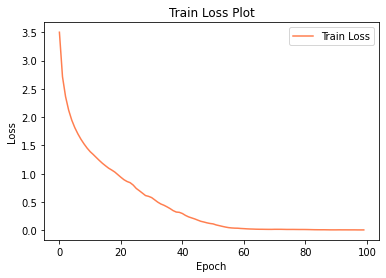

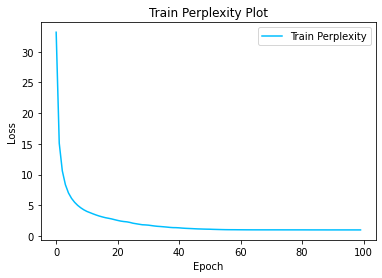

In [6]:
fable_samples = ['Dogs like best to', 'THERE were once some Frogs who lived together', 'THE WOMAN AND HER HEN']
get_fables()
PATH = book_path
trainer = Trainer(model_parameters = model_parameters, path = PATH, bptt_len = BPTT_LEN, samples = fable_samples)
print(f"Training on data from: {PATH}")
print("Fable Analysis")
counter(PATH)
print("Vocab Count: ", len(trainer.train_field.vocab))
print("Count: ", len(trainer.bptt_iterator))
fable_model = trainer.train_model(num_epochs=100)
torch.save(fable_model.state_dict(), 'fable_model.pt')

Word Count:  1785
Line Count:  1785
Char Count:  212573
Sentence Count:  4852
Vocab Count:  86
Count:  16
___________________________________________________________________________
EPOCH: 1
Total Steps: 0
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


Training Loss: 3.2571451514959335, 
 Training perplexity: 25.975275713377215
___________________________________________________________________________
EPOCH: 2
Total Steps: 16
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 2.4017930030822754, 
 Training perplexity: 11.042958699448073
___________________________________________________________________________
EPOCH: 3
Total Steps: 32
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 1.9851548224687576, 
 Training perplexity: 7.280174432783706
___________________________________________________________________________
EPOCH: 4
Total Steps: 48
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


Training Loss: 1.7022864744067192, 
 Training perplexity: 5.486477752057189
___________________________________________________________________________
EPOCH: 5
Total Steps: 64
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 1.5073883086442947, 
 Training perplexity: 4.514923795458787
___________________________________________________________________________
EPOCH: 6
Total Steps: 80
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 1.3672349900007248, 
 Training perplexity: 3.9244844410209088
___________________________________________________________________________
EPOCH: 7
Total Steps: 96
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 1.2644379809498787, 
 Training perplexity: 3.541102009960352
___________________________________________________________________________
EPOCH: 8
Total Steps: 112
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 1.1861360594630241, 
 Training perplexity: 3.2744046276046297
___________________________________________________________________________
EPOCH: 9
Total Steps: 128
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 1.1239720061421394, 
 Training perplexity: 3.0770520319013994
___________________________________________________________________________
EPOCH: 10
Total Steps: 144
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]



Greedy decoding
Sample prompt: Good morning America | generated text:  people that we will be the state of the problem the world and the world and the way we will be the 

Random decoding
Sample prompt: Good morning America | generated text:  Adread Washington Michiga walk about this thing, nuclup expers in the Bacmoss, and we reasons, you 


Greedy decoding
Sample prompt: Very good | generated text: to the problem the world and the world and the way we will be the state of the problem the world and

Random decoding
Sample prompt: Very good | generated text:  We whoweven to come. Thill he swinped her want to we cut beor. We’ve been to do, unforces I could f


Greedy decoding
Sample prompt: Donald Trump: | generated text: (01:01:00)<eos>I said, “What we will be the state of the problem the world and the world and the way we 

Random decoding
Sample prompt: Donald Trump: | generated text: (10:59)<eos>Now it’s very nimage First taxkes of door as bectar.<eos><eos>Vice President Donald J. 

100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 1.021485198289156, 
 Training perplexity: 2.777316568173853
___________________________________________________________________________
EPOCH: 12
Total Steps: 176
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.9770585708320141, 
 Training perplexity: 2.656630447774579
___________________________________________________________________________
EPOCH: 13
Total Steps: 192
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.9334794841706753, 
 Training perplexity: 2.5433433224025026
___________________________________________________________________________
EPOCH: 14
Total Steps: 208
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.8985811546444893, 
 Training perplexity: 2.456115789276545
___________________________________________________________________________
EPOCH: 15
Total Steps: 224
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.8648763820528984, 
 Training perplexity: 2.374712510746367
___________________________________________________________________________
EPOCH: 16
Total Steps: 240
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.8286845274269581, 
 Training perplexity: 2.2903039257477804
___________________________________________________________________________
EPOCH: 17
Total Steps: 256
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.7999284192919731, 
 Training perplexity: 2.225381628398538
___________________________________________________________________________
EPOCH: 18
Total Steps: 272
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.7654283158481121, 
 Training perplexity: 2.1499150201528425
___________________________________________________________________________
EPOCH: 19
Total Steps: 288
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.7253978252410889, 
 Training perplexity: 2.065552665523037
___________________________________________________________________________
EPOCH: 20
Total Steps: 304
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]



Greedy decoding
Sample prompt: Good morning America | generated text:  flag. And we will end our reliance on China on the state of Michigan, we will make America great ag

Random decoding
Sample prompt: Good morning America | generated text: s flast, counting for that? I saw so you from $10 million joins to continue to come the smart on Chi


Greedy decoding
Sample prompt: Very good | generated text:  And we will end our reliance on China on the state of Michigan, we will make America great again. T

Random decoding
Sample prompt: Very good | generated text:  And I think you’w ever wene. She reject on anyway, which was one people on really well. The great j


Greedy decoding
Sample prompt: Donald Trump: | generated text: (01:01:00)<eos>Well, he said, “I had a lot of work to do what we have to do what we have to do what we h

Random decoding
Sample prompt: Donald Trump: | generated text: (30:43)<eos>One, many is that he spent the disease. It wouldn’t feel that none so much. I said, “Be

100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.6751954779028893, 
 Training perplexity: 1.964416938544072
___________________________________________________________________________
EPOCH: 22
Total Steps: 336
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Training Loss: 0.6335835196077824, 
 Training perplexity: 1.8843511037785325
___________________________________________________________________________
EPOCH: 23
Total Steps: 352
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.5961959660053253, 
 Training perplexity: 1.8152005654745147
___________________________________________________________________________
EPOCH: 24
Total Steps: 368
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.5675549805164337, 
 Training perplexity: 1.7639488851923377
___________________________________________________________________________
EPOCH: 25
Total Steps: 384
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.5451462306082249, 
 Training perplexity: 1.7248605913490263
___________________________________________________________________________
EPOCH: 26
Total Steps: 400
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 0.5141462776809931, 
 Training perplexity: 1.6722102889899157
___________________________________________________________________________
EPOCH: 27
Total Steps: 416
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.48824636824429035, 
 Training perplexity: 1.6294562467995002
___________________________________________________________________________
EPOCH: 28
Total Steps: 432
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.462318466976285, 
 Training perplexity: 1.5877508689366553
___________________________________________________________________________
EPOCH: 29
Total Steps: 448
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.42731332406401634, 
 Training perplexity: 1.5331329539243383
___________________________________________________________________________
EPOCH: 30
Total Steps: 464
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]



Greedy decoding
Sample prompt: Good morning America | generated text:  dream. And as I said, “What the hell is going on? Is that the president said, “No, no, no, no, not 

Random decoding
Sample prompt: Good morning America | generated text:  dream. That was a Trump back, and I appreciate it. That’s all I case, but we want up, and we nave i


Greedy decoding
Sample prompt: Very good | generated text: ratings that they have to come in the one that nobody believed. It was one of the most invest the oi

Random decoding
Sample prompt: Very good | generated text: ratings to many of you have been to call Ever.<eos><eos>Donald Trump: (01:58:07)<eos>How a by the way, and that’


Greedy decoding
Sample prompt: Donald Trump: | generated text: (01:01:03)<eos>… some great warriors. I don’t know. I don’t know. I don’t know. I don’t know. I don’t kn

Random decoding
Sample prompt: Donald Trump: | generated text: (01:27:19)<eos>The only Marson and Kamala Harris is not good for the United States. I c

100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.37967382557690144, 
 Training perplexity: 1.4618077073794524
___________________________________________________________________________
EPOCH: 32
Total Steps: 496
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 0.34847475588321686, 
 Training perplexity: 1.4169047739623728
___________________________________________________________________________
EPOCH: 33
Total Steps: 512
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


Training Loss: 0.3280080817639828, 
 Training perplexity: 1.3882001913503847
___________________________________________________________________________
EPOCH: 34
Total Steps: 528
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 0.30459695030003786, 
 Training perplexity: 1.3560783258822273
___________________________________________________________________________
EPOCH: 35
Total Steps: 544
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 0.27801018580794334, 
 Training perplexity: 1.3204996474963928
___________________________________________________________________________
EPOCH: 36
Total Steps: 560
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 0.2531714681535959, 
 Training perplexity: 1.2881041267359776
___________________________________________________________________________
EPOCH: 37
Total Steps: 576
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 0.2338552512228489, 
 Training perplexity: 1.2634615944502097
___________________________________________________________________________
EPOCH: 38
Total Steps: 592
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 0.2146493373438716, 
 Training perplexity: 1.239427199920504
___________________________________________________________________________
EPOCH: 39
Total Steps: 608
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


Training Loss: 0.19454912468791008, 
 Training perplexity: 1.21476315628025
___________________________________________________________________________
EPOCH: 40
Total Steps: 624
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]



Greedy decoding
Sample prompt: Good morning America | generated text:  blood and treasure in endless foreign, ridiculous working all the time. Thank you very much, I appr

Random decoding
Sample prompt: Good morning America | generated text:  got each and sent and women of Willient New York 91p, some beautiful, beautiful Abriotits, ran expl


Greedy decoding
Sample prompt: Very good | generated text: ratings the things that the hell out of our country. I see who’s had so many different problem. Ever

Random decoding
Sample prompt: Very good | generated text: ratings the things that the great Whith you ever seen. And over administration?<eos><eos>Donald Trump: (02:3


Greedy decoding
Sample prompt: Donald Trump: | generated text: (01:21:11)<eos>No, we’ve done a good job. They loved how to do it. It’s not fair. You’re sending them ba

Random decoding
Sample prompt: Donald Trump: | generated text: (01:51:41)<eos>Joe Biden stated with oil against fracking. The only bad under President and

100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 0.17467504926025867, 
 Training perplexity: 1.190859183159865
___________________________________________________________________________
EPOCH: 42
Total Steps: 656
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.162528021261096, 
 Training perplexity: 1.1764812844760604
___________________________________________________________________________
EPOCH: 43
Total Steps: 672
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.14813608769327402, 
 Training perplexity: 1.159670702535857
___________________________________________________________________________
EPOCH: 44
Total Steps: 688
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.1386572546325624, 
 Training perplexity: 1.148730310530332
___________________________________________________________________________
EPOCH: 45
Total Steps: 704
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.1266387738287449, 
 Training perplexity: 1.1350069495075306
___________________________________________________________________________
EPOCH: 46
Total Steps: 720
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Training Loss: 0.11229809606447816, 
 Training perplexity: 1.1188463346280433
___________________________________________________________________________
EPOCH: 47
Total Steps: 736
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.09663460543379188, 
 Training perplexity: 1.1014578333752574
___________________________________________________________________________
EPOCH: 48
Total Steps: 752
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.08705348987132311, 
 Training perplexity: 1.0909550332019489
___________________________________________________________________________
EPOCH: 49
Total Steps: 768
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.07698982208967209, 
 Training perplexity: 1.080031083877137
___________________________________________________________________________
EPOCH: 50
Total Steps: 784
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]



Greedy decoding
Sample prompt: Good morning America | generated text: strong again. We have made America proud again. We have made America safe again, and we will make Am

Random decoding
Sample prompt: Good morning America | generated text:  economy from the world, and now they all was the great plague, and they want to touch. They want to


Greedy decoding
Sample prompt: Very good | generated text: ratings the other night, a fake report, but the ratings go through the roof. 60 Minutes had very goo

Random decoding
Sample prompt: Very good | generated text: allying the fastest growth, by the way, do. I think they’d been fighting for 400 years, you want to 


Greedy decoding
Sample prompt: Donald Trump: | generated text: (01:11:03)<eos>For years, you had a president who apologized for America. Now you have a president who i

Random decoding
Sample prompt: Donald Trump: | generated text: (01:01:24)<eos>A vote for sleepy Joe, at the announcer, ran refugees and what’s right for the White

100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.06545031210407615, 
 Training perplexity: 1.0676396872258722
___________________________________________________________________________
EPOCH: 52
Total Steps: 816
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Training Loss: 0.05995371378958225, 
 Training perplexity: 1.0617873992929658
___________________________________________________________________________
EPOCH: 53
Total Steps: 832
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.050775231095030904, 
 Training perplexity: 1.0520863903990496
___________________________________________________________________________
EPOCH: 54
Total Steps: 848
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Training Loss: 0.0448023471981287, 
 Training perplexity: 1.0458211300024163
___________________________________________________________________________
EPOCH: 55
Total Steps: 864
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Training Loss: 0.03998419945128262, 
 Training perplexity: 1.0407943289409674
___________________________________________________________________________
EPOCH: 56
Total Steps: 880
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.036542543675750494, 
 Training perplexity: 1.0372184301636742
___________________________________________________________________________
EPOCH: 57
Total Steps: 896
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.03209973324555904, 
 Training perplexity: 1.032620486762271
___________________________________________________________________________
EPOCH: 58
Total Steps: 912
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.027843429939821362, 
 Training perplexity: 1.0282346810517102
___________________________________________________________________________
EPOCH: 59
Total Steps: 928
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.023934513214044273, 
 Training perplexity: 1.0242232426061137
___________________________________________________________________________
EPOCH: 60
Total Steps: 944
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]



Greedy decoding
Sample prompt: Good morning America | generated text:  blood and treasure in endless foreign wars in countries that most of you have never even heard of, 

Random decoding
Sample prompt: Good morning America | generated text:  unemployment all reached their lowest levels, ever recorded. Think of that, what we had going and w


Greedy decoding
Sample prompt: Very good | generated text:  She would call me, I’d come. I’d make a speech, I’d leave. Call me the next day.<eos><eos>Donald Trump: (01

Random decoding
Sample prompt: Very good | generated text:  State, You know, we have to wrong for a long time. You’re going to do the job we’ve done, when we h


Greedy decoding
Sample prompt: Donald Trump: | generated text: (01:11:03)<eos>Michigan gave us Motown, the Mustang and the unrivaled might of the American Midwest, the

Random decoding
Sample prompt: Donald Trump: | generated text: (01:01:09)<eos>“Sir, you have to do this? You have to get out the great people of Michigan.

100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.020796125754714012, 
 Training perplexity: 1.0210138719844375
___________________________________________________________________________
EPOCH: 62
Total Steps: 976
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 0.01960402785334736, 
 Training perplexity: 1.019797448682266
___________________________________________________________________________
EPOCH: 63
Total Steps: 992
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.018446171190589666, 
 Training perplexity: 1.0186173527344635
___________________________________________________________________________
EPOCH: 64
Total Steps: 1008
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 0.017899772385135293, 
 Training perplexity: 1.018060933456972
___________________________________________________________________________
EPOCH: 65
Total Steps: 1024
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.016348902776371688, 
 Training perplexity: 1.016483277381049
___________________________________________________________________________
EPOCH: 66
Total Steps: 1040
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.015064496721606702, 
 Training perplexity: 1.0151785381918397
___________________________________________________________________________
EPOCH: 67
Total Steps: 1056
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 0.012971938063856214, 
 Training perplexity: 1.0130564386358374
___________________________________________________________________________
EPOCH: 68
Total Steps: 1072
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.011608745087869465, 
 Training perplexity: 1.0116763880657444
___________________________________________________________________________
EPOCH: 69
Total Steps: 1088
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.010624007845763117, 
 Training perplexity: 1.0106806430035449
___________________________________________________________________________
EPOCH: 70
Total Steps: 1104
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]



Greedy decoding
Sample prompt: Good morning America | generated text:  blood and treasure in endless foreign, ridiculous wars. Countries you’ve never even heard of. In 20

Random decoding
Sample prompt: Good morning America | generated text:  blood and treasure on foreign Wars. You know what they call them? The endless foreign wars, countri


Greedy decoding
Sample prompt: Very good | generated text: all over. We have to do it. It’s just we could be a little bit superstitious, right? But you people,

Random decoding
Sample prompt: Very good | generated text: all over the last few years. A lot of great things. And you’re paying, what, $2 a gallon for your ga


Greedy decoding
Sample prompt: Donald Trump: | generated text: (01:51:31)<eos>No, he’s the best loser I’ve ever seen. He could lose … He lost with Hillary and they did

Random decoding
Sample prompt: Donald Trump: | generated text: (01:52:41)<eos>o let me saved to the people of Michigan. Now it’s our taxes.” I never heard that be

100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.008756377879763022, 
 Training perplexity: 1.0087948270999114
___________________________________________________________________________
EPOCH: 72
Total Steps: 1136
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


Training Loss: 0.007955691777169704, 
 Training perplexity: 1.007987422383488
___________________________________________________________________________
EPOCH: 73
Total Steps: 1152
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 0.007351701467996463, 
 Training perplexity: 1.0073787915706587
___________________________________________________________________________
EPOCH: 74
Total Steps: 1168
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.0067021446011494845, 
 Training perplexity: 1.0067246542317778
___________________________________________________________________________
EPOCH: 75
Total Steps: 1184
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 0.006214951368747279, 
 Training perplexity: 1.0062343042506388
___________________________________________________________________________
EPOCH: 76
Total Steps: 1200
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 0.0059674931690096855, 
 Training perplexity: 1.0059853341273146
___________________________________________________________________________
EPOCH: 77
Total Steps: 1216
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 0.005637408728944138, 
 Training perplexity: 1.0056533288194924
___________________________________________________________________________
EPOCH: 78
Total Steps: 1232
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 0.00524668357684277, 
 Training perplexity: 1.0052604715242395
___________________________________________________________________________
EPOCH: 79
Total Steps: 1248
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Training Loss: 0.004952140967361629, 
 Training perplexity: 1.004964423083329
___________________________________________________________________________
EPOCH: 80
Total Steps: 1264
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]



Greedy decoding
Sample prompt: Good morning America | generated text:  blood and treasure in endless foreign, ridiculous wars. Countries you’ve never even heard of. In 20

Random decoding
Sample prompt: Good morning America | generated text:  plague and we’re going to pull it tomorrow. So I got to ask you to do a couple of things. Air Force


Greedy decoding
Sample prompt: Very good | generated text: ratings the other night, a fake report, but the ratings go through the roof.<eos><eos>Donald Trump: (11:35)<eos>

Random decoding
Sample prompt: Very good | generated text: ratings the other night, a fake report, but the ratings go through the roof.<eos><eos>Donald Trump: (11:35)<eos>


Greedy decoding
Sample prompt: Donald Trump: | generated text: (01:40:53)<eos>This is the only man that I’ve ever seen run for office on the fact that he wants to give

Random decoding
Sample prompt: Donald Trump: | generated text: (01:41:03)<eos>You know what? I wasn’t going to take my chance. I said, “Yo

100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.004579582076985389, 
 Training perplexity: 1.0045900843889317
___________________________________________________________________________
EPOCH: 82
Total Steps: 1296
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.0044949140574317425, 
 Training perplexity: 1.0045050313367108
___________________________________________________________________________
EPOCH: 83
Total Steps: 1312
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.004183710261713713, 
 Training perplexity: 1.0041924741951478
___________________________________________________________________________
EPOCH: 84
Total Steps: 1328
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.003944873664295301, 
 Training perplexity: 1.0039526649202135
___________________________________________________________________________
EPOCH: 85
Total Steps: 1344
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.003789000169490464, 
 Training perplexity: 1.0037961875053714
___________________________________________________________________________
EPOCH: 86
Total Steps: 1360
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.00366502815450076, 
 Training perplexity: 1.0036717525827508
___________________________________________________________________________
EPOCH: 87
Total Steps: 1376
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.0036175523709971458, 
 Training perplexity: 1.0036241036110114
___________________________________________________________________________
EPOCH: 88
Total Steps: 1392
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.00347554667678196, 
 Training perplexity: 1.0034815933923178
___________________________________________________________________________
EPOCH: 89
Total Steps: 1408
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.003400022746063769, 
 Training perplexity: 1.0034058093797709
___________________________________________________________________________
EPOCH: 90
Total Steps: 1424
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]



Greedy decoding
Sample prompt: Good morning America | generated text:  plague. I’m make a speech, I’d leave. Call me the next day.<eos><eos>Donald Trump: (01:01:09)<eos>“Sir, you hav

Random decoding
Sample prompt: Good morning America | generated text:  blood and treasure on foreign Wars. You know what they call them? The endless foreign wars, countri


Greedy decoding
Sample prompt: Very good | generated text: ratings the other night, a fake report, but the ratings go through the roof.<eos><eos>Donald Trump: (11:35)<eos>

Random decoding
Sample prompt: Very good | generated text:  She did a great job. Thank you, honey, thank you very much. And Michael, thank you very much. Thank


Greedy decoding
Sample prompt: Donald Trump: | generated text: (01:40:50)<eos>This group over here. They’re an activist group. Thank you very much. Thank you, fellas.<eos>

Random decoding
Sample prompt: Donald Trump: | generated text: (01:09:24)<eos>America will land the first woman on the moon, and the U

100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.0032626007014187053, 
 Training perplexity: 1.0032679287759714
___________________________________________________________________________
EPOCH: 92
Total Steps: 1456
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.0032148269965546206, 
 Training perplexity: 1.0032200000949167
___________________________________________________________________________
EPOCH: 93
Total Steps: 1472
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.003133122925646603, 
 Training perplexity: 1.0031380362853268
___________________________________________________________________________
EPOCH: 94
Total Steps: 1488
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Training Loss: 0.003094815998338163, 
 Training perplexity: 1.0030996098854938
___________________________________________________________________________
EPOCH: 95
Total Steps: 1504
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Training Loss: 0.00312476851104293, 
 Training perplexity: 1.0031296556892744
___________________________________________________________________________
EPOCH: 96
Total Steps: 1520
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.003021825512405485, 
 Training perplexity: 1.0030263958295267
___________________________________________________________________________
EPOCH: 97
Total Steps: 1536
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.0029716700955759734, 
 Training perplexity: 1.0029760898841211
___________________________________________________________________________
EPOCH: 98
Total Steps: 1552
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Training Loss: 0.002815191837726161, 
 Training perplexity: 1.0028191582114288
___________________________________________________________________________
EPOCH: 99
Total Steps: 1568
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Training Loss: 0.002792594736092724, 
 Training perplexity: 1.002796497661023
___________________________________________________________________________
EPOCH: 100
Total Steps: 1584
___________________________________________________________________________


100%|██████████| 16/16 [00:08<00:00,  1.81it/s]



Greedy decoding
Sample prompt: Good morning America | generated text:  plague. I’m make a speech, I’d leave. Call me the next day.<eos><eos>Donald Trump: (01:01:09)<eos>“Sir, you hav

Random decoding
Sample prompt: Good morning America | generated text:  life and next year will be the greatest economic year in the history of our country. That’s where w


Greedy decoding
Sample prompt: Very good | generated text: ratings the other night, a fake report, but the ratings go through the roof.<eos><eos>Donald Trump: (11:35)<eos>

Random decoding
Sample prompt: Very good | generated text: all over. We have to do it. It’s just we could be a little bit superstitious, right? But you people,


Greedy decoding
Sample prompt: Donald Trump: | generated text: (01:40:50)<eos>This group over here. They’re an activist group. Thank you very much. Thank you, fellas.<eos>

Random decoding
Sample prompt: Donald Trump: | generated text: (01:40:40)<eos>And you know what? It was a disaster. He was a disaster.

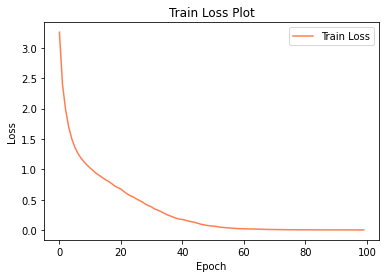

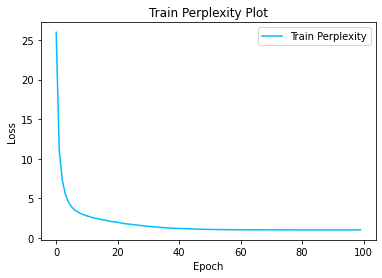

In [7]:
trump_samples = ['Good morning America', 'Very good', 'Donald Trump:']
PATH = bonus_path
trainer = Trainer(model_parameters = model_parameters, path = PATH, bptt_len = BPTT_LEN, samples = trump_samples)
counter(PATH)
print("Vocab Count: ", len(trainer.train_field.vocab))
print("Count: ", len(trainer.bptt_iterator))
trump_model = trainer.train_model(num_epochs=100)
torch.save(trump_model.state_dict(), 'trump_model.pt')

# Load Fable and Trump models

In [8]:
# Fable Model
PATH = book_path
fable_trainer = Trainer(model_parameters = model_parameters, path = PATH, bptt_len = BPTT_LEN, samples = fable_samples)
fable_model = fable_trainer.model
fable_model.load_state_dict(torch.load('fable_model.pt'))

# Trump Model
PATH = bonus_path
trump_trainer = Trainer(model_parameters = model_parameters, path = PATH, bptt_len = BPTT_LEN, samples = trump_samples)
trump_model = trump_trainer.model
trump_model.load_state_dict(torch.load('trump_model.pt'))


<All keys matched successfully>

# Greedy decoding for the fable model

In [10]:
trainer = fable_trainer
#Greedy
prompt = 'THE FOX AND THE LION'
gen_text = trainer.predict(fable_model,prompt,300)
print("Greedy Decoding")
print("A title in the book")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')

#A title which you invent, which is not in the book, but similar in the style.
prompt = 'THE TURTLE AND THE BIRD'
gen_text = fable_trainer.predict(fable_model,prompt,300)
print("A title in similar style")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
# Some texts in a similar style.
print("Some texts in similar style")
prompt = 'Back in my day'
gen_text = trainer.predict(fable_model,prompt,300)
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#Anything you might find interesting
print("Anything Interesting")
prompt = 'Dallmayr to go'
gen_text = trainer.predict(fable_model,prompt,300)
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = 'Covid-19 is'
gen_text = trainer.predict(fable_model,prompt,300)
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#Multinomial
print("Random Decoding")
print("A title in the book")
prompt = 'THE FOX AND THE LION'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#A title which you invent, which is not in the book, but similar in the style.
print("A title in similar style")
prompt = 'THE TURTLE AND THE BIRD'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
# Some texts in a similar style.
print("Some texts in similar style")
prompt = 'Back in my day'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#Anything you might find interesting
print("Anything Interesting")
prompt = 'Dallmayr to go'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = 'Covid-19 is'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = 'The Angry Turtle was'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')

#Greedy
print("Greedy Decoding")

prompt = ' '
gen_text = trainer.predict(fable_model,prompt,300)
print("A title in the book")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#A title which you invent, which is not in the book, but similar in the style.
prompt = 'A very nice day'
gen_text = trainer.predict(fable_model,prompt,300)
print("A title in similar style")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
# Some texts in a similar style.
prompt = 'I once was'
gen_text = trainer.predict(fable_model,prompt,300)
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#Anything you might find interesting
print("Anything Interesting")
prompt = 'Birds are flying'
gen_text = trainer.predict(fable_model,prompt,300)
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = 'Coca Cola'
gen_text = trainer.predict(fable_model,prompt,300)
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#Multinomial





Greedy Decoding
A title in the book
Sample prompt: THE FOX AND THE LION | generated text: <eos><eos>THE first time the Fox saw the Lion, he was ready to die of fear. The<eos>second time he took courage and could even bear to look upon him. The<eos>third time he had the impudence to come up to him, to salute him, and<eos>to enter into familiar conversation with him.<eos><eos><eos><eos><eos>THE DOG AND HIS SHADOW<eos><eos><eos>A DOG had sto
A title in similar style
Sample prompt: THE TURTLE AND THE BIRD | generated text: <eos><eos><eos>TWO Women all who had guessed the tree, the Dog indignant, and each plucking<eos>from the Jackdaw his own kind of feathers, they left the proposed king<eos>a plain Jackdaw with no claim to superior beauty.<eos><eos><eos><eos><eos>THE DONKEY AND THE LAP DOG<eos><eos><eos>THERE was once a man who had a Donkey and a little pet Dog. The Do
Some texts in similar style
Sample prompt: Back in my day | generated text:  and a Fox and was easily to get out of<eos>si

# Random decoding for the fable model

In [12]:
trainer = fable_trainer
print("Random Decoding")
prompt = ' '
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#A title which you invent, which is not in the book, but similar in the style.
prompt = 'A very nice day'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
# Some texts in a similar style.
prompt = 'I once was'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#Anything you might find interesting"
print("Anything Interesting")
prompt = 'Birds are flying'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = 'Coca Cola'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = 'The Fox'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')

prompt = 'The Angry Turtle was'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')



Random Decoding
Sample prompt:   | generated text: aid White-whisker; “she is so bold we could not frighten her. I<eos>have thought of something better than that. Let us hang a bell round<eos>her neck. Then, if she moves, the bell will ring, and we shall hear it, it<eos>he saw his mother will nature should not have been, for a year ago I was<eos>not born.”<eos><eos>“Well, 
Sample prompt: A very nice day | generated text: <eos>I meant, the Dove killed him with others, that it was<eos>not quiet like the pond, and the horses made the water muddy and foul.<eos><eos>One day the Frog from the pond said to the other, “Do come and live<eos>with me; I have plenty of food and water, and nothing to disturb me;<eos>and it is so pleasant in my pond. No
Sample prompt: I once was | generated text: my strong rope, proyong<eos>meat, you must have a part of though I but see<eos>the way.”<eos><eos>“Oh, then we may help each other,” said the Lame Man. “If you will take<eos>me on your shoulders, we will se

# Greedy decoding for the trump model

In [13]:
trainer = trump_trainer
#Greedy
prompt = 'Thank You'
gen_text = trainer.predict(trump_model,prompt,300)
print("Greedy Decoding")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#A title which you invent, which is not in the book, but similar in the style.
prompt = 'Good'
gen_text = trainer.predict(trump_model,prompt,300)
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
# Some texts in a similar style.
prompt = 'China'
gen_text = trainer.predict(trump_model,prompt,300)
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#Anything you might find interesting
prompt = 'We have to'
gen_text = trainer.predict(trump_model,prompt,300)
print(f'Sample prompt: {prompt} | generated text: {gen_text}')


Greedy Decoding
Sample prompt: Thank You | generated text: for the year. “Where’s Hunter?”<eos><eos>Donald Trump: (01:57:59)<eos>You know where Hunter is? He’s buying vacuum cleaners, because he follows his father and he vacuums in money from every country that his father sees. No, seriously, Ukraine. His father was a judge of Russia, Ukraine, and China. President Obam
Sample prompt: Good | generated text:  You know, we have to win both Nebraska’s, you know that right? You have two, you’re cut. We’re going to win both. This election is a choice between the Trump super recovery, which is what we’re having, or a Biden depression, sad to say. And some bad news just came out on Biden. But I won’t tell you
Sample prompt: China | generated text: will own the USA. If Biden wins he will do bad things. By the way, he’s not a good guy. Just so you understand.<eos><eos>Donald Trump: (08:20)<eos>Is there any place you would rather be than a Trump rally on about a 10 degree evening? 10 degrees. Yea

# Random decoding for the trump model

In [14]:
trainer = trump_trainer

print("Random Decoding")
prompt = 'Thank You'
gen_text = trainer.predict(trump_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#A title which you invent, which is not in the book, but similar in the style.
prompt = 'Good'
gen_text = trainer.predict(trump_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
# Some texts in a similar style.
prompt = 'China'
gen_text = trainer.predict(trump_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
#Anything you might find interesting
prompt = 'We have to'
gen_text = trainer.predict(trump_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = ' '
gen_text = trainer.predict(trump_model,prompt,1000,method="greedy")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = ' '
gen_text = trainer.predict(trump_model,prompt,1000,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
print("Something not in the text")

Random Decoding
Sample prompt: Thank You | generated text: for the great people of… How many times did he do that? Seven? Standing up for the great people of Iowa. “Sir, sir, it’s Michigan.” There’s no recovery from that, right? When you do that, you just walk off the stage, right? I always say the great Winston Churchill, he was a great orator, even if Win
Sample prompt: Good | generated text:  Thank you. Thank you. Thank you must more things to do. I try and stay uninvolved. Going too slowly. “No sir, we’d rather not do anything before the election.” Well they did it to me before, they did during, before, and after. These are bad people, Comey, the worst director in the history of the FB
Sample prompt: China | generated text: plague. That’s what I tested positive for. But it was amazing. And it was actually an experience.<eos><eos>Donald Trump: (26:04)<eos>And until I came along, you were supposed to have lifetime immunity. Right? I said, “Well, I’m recovered. I feel great. And I’m i

# Comparing random and greedy for both models

In [15]:
trainer = fable_trainer
print("Random Decoding")
prompt = 'Birds fly high'
gen_text = trainer.predict(fable_model,prompt,300,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = 'Birds fly high'
print("Greedy Decoding")
gen_text = trainer.predict(fable_model,prompt,300,method="greedy")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = '<eos>'
gen_text = trainer.predict(fable_model,prompt,600,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
gen_text = trainer.predict(fable_model,prompt,600,method="greedy")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')

prompt = 'THE WOLF AND THE LAMB'
gen_text = trainer.predict(fable_model,prompt,1000,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
prompt = 'THE WOLF AND THE LAMB'
gen_text = trainer.predict(fable_model,prompt,1000,method="greedy")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')

trainer = trump_trainer
print("Greedy Decoding")
prompt = "President Donald J. Trump: "
gen_text = trainer.predict(trump_model,prompt,600,method="greedy")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')
print("Random Decoding")
prompt = "President Donald J. Trump: "
gen_text = trainer.predict(trump_model,prompt,600,method="random")
print(f'Sample prompt: {prompt} | generated text: {gen_text}')

Random Decoding
Sample prompt: Birds fly high | generated text: up a forest, and made<eos>redy some one to advise.<eos><eos><eos><eos><eos>THE KID AND THE WOLF<eos><eos><eos>A KID coming home alone one night met a big Wolf. “Oh, oh, I know you<eos>will kill me,” said the little Kid; “but please play me a tune, so that<eos>I may have one more dance before I die; I am so fond of dancing.”<eos><eos>“Very well,” said
Greedy Decoding
Sample prompt: Birds fly high | generated text: up a forest, and made<eos>ready to spring upon him. Away went the stag! and the legs that he had<eos>despised would soon have carried him out of danger; but when he came to<eos>the thick woods, his beautiful antlers, of which he had been so vain,<eos>caught in the branches and held him fast until the lion came up a
Sample prompt: <eos> | generated text: and it. She stones that he might<eos>persuade to help her pick up the seeds which the farmer had sown.<eos><eos>By and by the flax sprang up, and the Swallow tried